In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import eqmarl

In [13]:
import gymnasium as gym
import minigrid # Must import minigrid after gymnasium to register the environments properly.
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

In [14]:
def generate_model_actor_classical_shared_mdp(n_actions: int, units: list[int], activation: str = 'relu', **kwargs) -> keras.Model:
    assert type(units) == list, 'units must be a list of integers'
    layers = []
    layers += [keras.layers.Flatten()]
    layers += [keras.layers.Dense(u, activation=activation) for u in units]
    layers += [keras.layers.Dense(n_actions, activation='softmax', name='policy')] # Policy estimation pi(a|s)
    model = keras.Sequential(layers=layers, **kwargs)
    return model

def generate_model_critic_classical_joint_mdp_central(n_agents: int, units: list[int], activation: str = 'relu', **kwargs) -> keras.Model:
    assert type(units) == list, 'units must be a list of integers'
    layers = []
    layers += [keras.layers.Flatten()] # Flatten all inputs.
    layers += [keras.layers.Dense(u, activation=activation) for u in units] # Central branch dense layers.
    layers += [keras.layers.Dense(1, activation=None, name='v')] # Value function estimator V(s).
    model = keras.Sequential(layers=layers, **kwargs)
    return model

In [ ]:
from eqmarl.layers import HybridVariationalEncodingPQC, RescaleWeighted
from eqmarl.ops import ParameterizedRotationLayer_RxRyRz
import cirq
import functools as ft

def generate_model_MiniGrid_critic_quantum_central_mdp(
    n_agents: int,
    n_layers: int,
    squash_activation: str = 'arctan', # linear, arctan/atan, tanh
    beta: float = 1.0,
    name: str = None,
    nn_activation: str = 'linear',
    trainable_w_enc: bool = True,
    ):
    """Centralized variant of hybrid joint quantum critic for MiniGrid.
    """

    # Shape of observables is already known for MiniGrid.
    obs_shape = (7,7,3)

    # Qubit dimension is pre-determined for MiniGrid environment.
    # Using `4` to match observable dimension.
    d_qubits_per_agent = 4
    d_qubits = d_qubits_per_agent * n_agents

    # Create qubit list using qubit dimensions.
    qubits = cirq.LineQubit.range(d_qubits)

    # Observables is joint Pauli product across all qubits.
    observables = [ft.reduce(lambda x,y: x*y, [cirq.Z(q) for q in qubits])]

    # Define quantum layer.
    qlayer = HybridVariationalEncodingPQC(
        qubits=qubits, 
        d_qubits=d_qubits,
        n_layers=n_layers,
        observables=observables,
        squash_activation=squash_activation,
        encoding_layer_cls=ParameterizedRotationLayer_RxRyRz,
        trainable_w_enc=trainable_w_enc,
        )

    model = keras.Sequential([
            keras.Input(shape=(n_agents, *obs_shape), dtype=tf.dtypes.float32, name='input'), # Shape of model input, which should match the observation vector shape.
            keras.Sequential([
                keras.layers.Reshape((n_agents,-1)), # Flatten each agent's observations.
                keras.layers.LocallyConnected1D(d_qubits_per_agent * 3, kernel_size=1, activation=nn_activation), # Reduce last feature dimension to (n_agents,d_qubits,3), use local dense units only to separate agents.
                keras.layers.Reshape((n_agents*d_qubits_per_agent,3)),
                ], name="input-preprocess"),
            qlayer,
            keras.Sequential([
                RescaleWeighted(len(observables)),
                keras.layers.Lambda(lambda x: x * beta),
                ], name='observables-value')
        ], name=name)
    return model

In [ ]:
import minigrid.wrappers


n_agents = 2
n_actions = 3 # 0=left, 1=right, 2=forward.
# env_id = "MiniGrid-LavaGapS5-v0"
env_id = "MiniGrid-Empty-5x5-v0"
# env_id = "MiniGrid-Empty-8x8-v0"
max_steps_per_episode = 50
env_vec = gym.vector.make(env_id, num_envs=n_agents, wrappers=[
    minigrid.wrappers.ImgObsWrapper,
    eqmarl.wrappers.StepRewardWrapper,
    minigrid.wrappers.ActionBonus,
], render_mode="rgb_array", max_steps=max_steps_per_episode)
obs_shape = env_vec.observation_space.shape[1:]
obs_shape

2024-11-20 20:49:18.999992: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-20 20:49:18.999993: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(7, 7, 3)

In [ ]:
units = [100]
learning_rate = 1.0e-4 
model_actor = generate_model_actor_classical_shared_mdp(
    n_actions=n_actions,
    units=units,
    name='qfctde-actor',
)
model_actor.build([None, *obs_shape])
optimizer_actor = keras.optimizers.Adam(learning_rate=learning_rate)
model_critic = generate_model_MiniGrid_critic_quantum_central_mdp(
    n_agents=n_agents,
    n_layers=5,
    squash_activation='arctan', # linear, arctan/atan, tanh
    name='qfctde-critic',
    nn_activation='linear',
    trainable_w_enc=False,
)
model_critic.build([None, n_agents, *obs_shape])
optimizer_critic = [
    keras.optimizers.Adam(learning_rate=1.0e-3), # dense kernel
    keras.optimizers.Adam(learning_rate=1.0e-3), # dense bias
    keras.optimizers.Adam(learning_rate=1.0e-2), # w_var
    # keras.optimizers.Adam(learning_rate=1.0e-2), # w_enc
    keras.optimizers.Adam(learning_rate=1.0e-1), # obs_weights
]

model_actor.summary()
model_critic.summary()

Model: "qfctde-actor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 147)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               14800     
                                                                 
 policy (Dense)              (None, 3)                 303       
                                                                 
Total params: 15,103
Trainable params: 15,103
Non-trainable params: 0
_________________________________________________________________
Model: "qfctde-critic"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-preprocess (Sequentia  (None, 8, 3)             3552      
 l)                                                              
                           

In [ ]:
algo = eqmarl.algorithms.MAA2C(
    env=env_vec,
    model_actor=model_actor,
    model_critic=model_critic,
    optimizer_actor=optimizer_actor,
    optimizer_critic=optimizer_critic,
    gamma=0.99,
    alpha=0.001,
    )

In [20]:
n_episodes = 1000
reward_history, metrics_history = algo.train(
    n_episodes=n_episodes,
    max_steps_per_episode=max_steps_per_episode,
)

Training for 1000 episodes, press 'Ctrl+C' to terminate early
Episode 1000: 100%|██████████| 1000/1000 [22:19<00:00,  1.34s/episode, episode_reward=[-97.71063264 -97.29712482]]


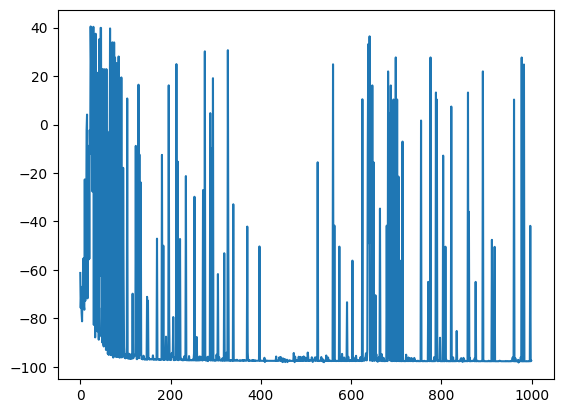

In [21]:
y = np.mean(reward_history, axis=1)
x = np.arange(len(y))
plt.plot(x, y)

In [22]:
np.savetxt("minigrid-qfctde-rewards.csv", reward_history, delimiter=',')

In [38]:
from IPython.display import HTML
import matplotlib.animation as animation

def animate(imgs: list, type='js', title=None): # 'js' or 'html'

    # Create figure and axes
    fig, ax = plt.subplots()
    if title:
        fig.suptitle(title)

    def _animate(i):
        ax.clear()
        ax.imshow(imgs[i])
        ax.set_title(f"step {i}")

    anim = animation.FuncAnimation(fig, _animate, frames=len(imgs), interval=200)

    # Convert the animation to HTML5 video
    # HTML(anim.to_html5_video())
    if type == 'js':
        return HTML(anim.to_jshtml())
    else:
        return HTML(anim.to_html5_video())

In [ ]:
def run(env, model_actor):
    actions = []
    rewards = []
    imgs = []
    s, info = env.reset()
    imgs.append(env.render())
    for t in range(max_steps_per_episode):
        s = tf.convert_to_tensor(s)
        s = tf.reshape(s, (-1, *s.shape))

        action_probs = model_actor(s)
        
        # Sample action from estimated probability distribution.
        action = np.random.choice(action_probs.shape[-1], p=np.squeeze(action_probs))
        
        s, reward, terminated, truncated, info  = env.step(action)
        actions.append(action)
        rewards.append(reward)
        
        img = env.render()
        imgs.append(img)
        
        if terminated:
            break
    return imgs, actions, rewards

In [25]:
env = gym.make(env_id, render_mode="rgb_array")
env = minigrid.wrappers.ImgObsWrapper(env)
imgs, _, _ = run(env, model_actor)
print(f"{len(imgs)-1} steps")

50 steps


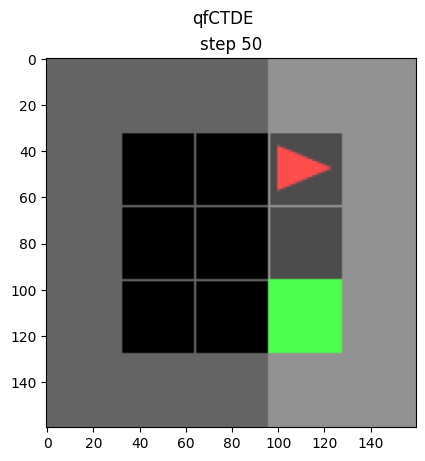

In [39]:
animate(imgs, type='js', title='qfCTDE')

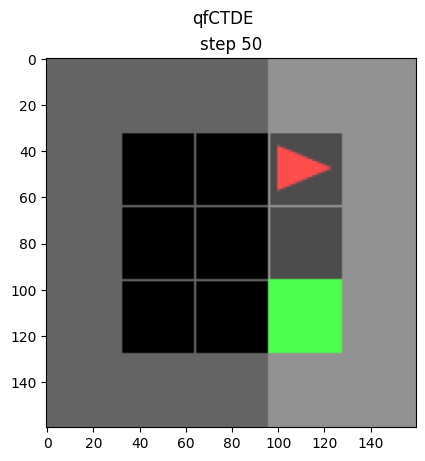

In [40]:
animate(imgs, type='html', title='qfCTDE')

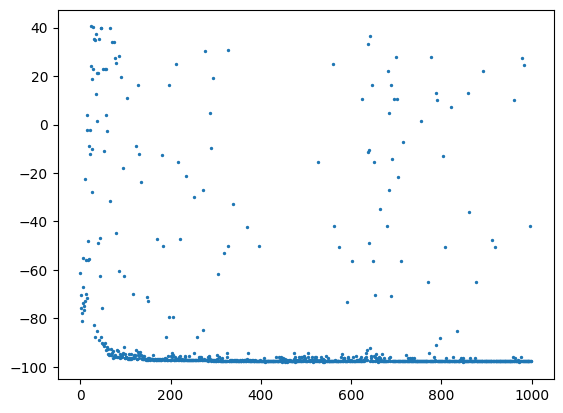

In [35]:
y = np.mean(reward_history, axis=1)
x = np.arange(len(y))
plt.scatter(x, y, s=2)